In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

2.2.1+cpu False


In [2]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

ERROR: Invalid requirement: "'git+https://github.com/facebookresearch/detectron2.git'"

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pandas as pd 

from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm # progress bar
from tqdm.notebook import tqdm
tqdm.pandas()

from datetime import datetime
import time
import matplotlib.pyplot as plt

import os, json, cv2, random
import skimage.io as io
import copy
from pathlib import Path
from typing import Optional
import json
import matplotlib.pyplot as plt

import ast


from tqdm import tqdm
import itertools

import torch
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from glob import glob
import numba
from numba import jit

from pycocotools.coco import COCO
# detectron2
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils


from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset



from detectron2.evaluation.evaluator import DatasetEvaluator
import pycocotools.mask as mask_util
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer

setup_logger()

<Logger detectron2 (DEBUG)>

In [48]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [49]:
def resize_and_scale(image_path, label_path, new_shape=(448, 448)):
    # Read the image file and decode it to a tensor
    file = tf.io.read_file(image_path)
    img = tf.image.decode_image(file, channels=3)

    # Resize the image to the specified new_shape
    img = tf.image.resize(img, new_shape)

    # Normalize the pixel values of the image to [0, 1]
    img = img / 255.0

    # Calculate the scale factors for the bounding box coordinates
    scale_factor_x = new_shape[0] / img.shape[0]
    scale_factor_y = new_shape[1] / img.shape[1]

    # Read and process the labels
    with open(label_path, 'r') as handle:
        labels = handle.readlines()
        
        all_labels = []
        
        for label in labels:
            label = label.replace('\n', '').split()
            label[0] = int(label[0])
            label[1] = float(label[1]) * scale_factor_x
            label[2] = float(label[2]) * scale_factor_y
            label[3] = float(label[3]) * scale_factor_x
            label[4] = float(label[4]) * scale_factor_y
            
            all_labels.append(label)
            
    return [img, all_labels]

In [50]:
def plot_bounding_boxes(image_tensor, boxes):
    # Convert the image tensor to a NumPy array if needed
    if isinstance(image_tensor, tf.Tensor):
        image_tensor = image_tensor.numpy()

    # Convert grayscale image to RGB if needed (to display the box in red)
    if len(image_tensor.shape) == 2:
        image_tensor = np.stack((image_tensor,) * 3, axis=-1)

    # Create a copy of the image to draw the bounding boxes
    image_with_boxes = np.copy(image_tensor)

    # Draw the bounding box on the image using PIL for each box
    box_color = (255, 0, 0)  # Red color
    thickness = 2  # Line thickness
    image_pil = Image.fromarray(np.uint8(image_with_boxes))
    draw = ImageDraw.Draw(image_pil)

    for box in boxes:
        cx, cy, w, h = box

        # Convert the normalized bounding box to absolute pixel values
        image_height, image_width = image_tensor.shape[:2]
        box_x = int(cx * image_width)
        box_y = int(cy * image_height)
        box_width = int(w * image_width)
        box_height = int(h * image_height)

        # Calculate the top-left and bottom-right coordinates of the bounding box
        top_left = (box_x - box_width // 2, box_y - box_height // 2)
        bottom_right = (box_x + box_width // 2, box_y + box_height // 2)

        # Draw the bounding box on the image
        draw.rectangle([top_left, bottom_right], outline=box_color, width=thickness)

    # Convert back to NumPy array and display the image with the bounding boxes
    image_with_boxes = np.array(image_pil)
    plt.imshow(image_with_boxes)
    plt.axis('off')  # Remove axis ticks and labels
    plt.show()

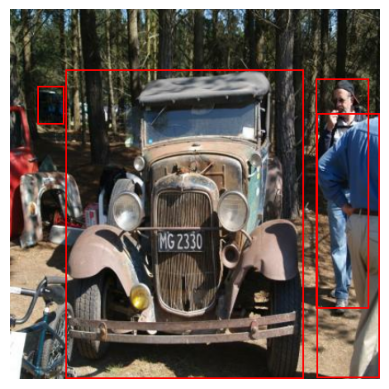

In [52]:
# Lets visualize one example
main_path = "evaluation-dataset/my-data/"
img_path = os.path.join(main_path, 'images/image_000000001_jpg.rf.02ab6664294833e5f0e89130ecded0b8.jpg')
label_path = os.path.join(main_path, 'labels/image_000000001_jpg.rf.02ab6664294833e5f0e89130ecded0b8.txt')

image, labels = resize_and_scale(img_path, label_path, new_shape=(448, 448))

boxes = [x[1:5] for x in labels]

plot_bounding_boxes(image * 255.0, boxes)

In [5]:
import os
import cv2
import pandas as pd

def get_image_dimensions(image_dir, image_name):
    image_path = os.path.join(image_dir, image_name + ".jpg")  # assuming images are .jpg files
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image {image_path} not found.")
    height, width = image.shape[:2]
    return width, height

def extract_bounding_boxes(labels_dir, image_dir):
    data = []
    for filename in os.listdir(labels_dir):
        if filename.endswith(".txt"):  # assuming the bounding box files have .txt extension
            image_name = os.path.splitext(filename)[0]
            width, height = get_image_dimensions(image_dir, image_name)
            with open(os.path.join(labels_dir, filename), 'r') as file:
                for line in file:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        _, x_center, y_center, bbox_width, bbox_height = map(float, parts)
                        xmin = int((x_center - bbox_width / 2) * width)
                        ymin = int((y_center - bbox_height / 2) * height)
                        xmax = int((x_center + bbox_width / 2) * width)
                        ymax = int((y_center + bbox_height / 2) * height)
                        data.append([image_name, xmin, ymin, xmax, ymax])
                    else:
                        print(f"Unexpected format in file: {filename}")
    return data

def create_csv(labels_dir, image_dir, output_csv):
    data = extract_bounding_boxes(labels_dir, image_dir)
    df = pd.DataFrame(data, columns=["image_name", "xmin", "ymin", "xmax", "ymax"])
    df.to_csv(output_csv, index=False)
    print(f"CSV file '{output_csv}' created successfully.")

# Usage
labels_directory = "evaluation-dataset/my-data/labels"  # path to your labels directory
image_directory = "evaluation-dataset/my-data/images"  # path to your images directory
output_csv_file = "bounding_boxes.csv"  # name of the output CSV file

create_csv(labels_directory, image_directory, output_csv_file)


CSV file 'bounding_boxes.csv' created successfully.


In [6]:
df_train = pd.read_csv('bounding_boxes.csv')

In [7]:
x_min = df_train['xmin']
y_min = df_train['ymin']
x_max = df_train['xmax']
y_max = df_train['ymax']
bboxes = list()
for i in range(len(x_min)):
    bboxes.append([[x_min[i],y_min[i],x_max[i],y_max[i]]])
df_train['bboxes'] = bboxes

In [9]:
df_train["Width"]=416
df_train["Height"]=416
df_train.sample(2)

,image_name,xmin,ymin,xmax,ymax,bboxes,Width,Height
580,image_000000337_jpg.rf.1ca26821298a393a4b2483c...,99,171,112,190,"[[99, 171, 112, 190]]",416,416
765,image_000000438_jpg.rf.c98f03d99a01411cabadc92...,115,212,271,257,"[[115, 212, 271, 257]]",416,416


In [26]:
train_path = 'evaluation-dataset/my-data/images/'
path = list()
for i in df_train['image_name']:
    path.append(train_path + i +".jpg")

In [35]:
df_train['image_path'] = path
df_train['image_path'][0]

'evaluation-dataset/my-data/images/image_000000001_jpg.rf.02ab6664294833e5f0e89130ecded0b8.jpg'

In [36]:
id = list()
for i in df_train['image_name']:
    id.append(i[:-4])

In [37]:
df_train['image_id'] = id
df_train.sample(2)

,image_name,xmin,ymin,xmax,ymax,bboxes,Width,Height,image_path,image_id,fold
171,image_000000058_jpg.rf.af9ed39710a9519dbe2d6e2...,101,255,121,296,"[[101, 255, 121, 296]]",416,416,evaluation-dataset/my-data/images/image_000000...,image_000000058_jpg.rf.af9ed39710a9519dbe2d6e2...,1
649,image_000000361_jpg.rf.962e403952836d1b6160ca8...,170,24,202,65,"[[170, 24, 202, 65]]",416,416,evaluation-dataset/my-data/images/image_000000...,image_000000361_jpg.rf.962e403952836d1b6160ca8...,0


In [38]:
n_spl=3
Selected_Fold=2 #0..2

from sklearn.model_selection import GroupKFold
gkf  = GroupKFold(n_splits = n_spl) # num_folds=3 as there are total 3 videos
df_train = df_train.reset_index(drop=True)
df_train['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(df_train, groups = df_train.image_id.tolist())):
    df_train.loc[val_idx, 'fold'] = fold
display(df_train.fold.value_counts())

fold
1    256
2    256
0    255
Name: count, dtype: int64

In [43]:
def get_data_dicts(
    _train_df: pd.DataFrame,
    debug: bool = False,
    data_type:str="train"
   
):

    if debug:
        _train_df = _train_df.iloc[:10]  # For debug...
    dataset_dicts = []
    if data_type=="train":
        _train_df=_train_df[_train_df.fold != Selected_Fold]
    else: # val
        _train_df=_train_df[_train_df.fold == Selected_Fold] 
        
    for index, row in tqdm(_train_df.iterrows(), total=len(_train_df)):
        record = {}
        filename  = row.image_path+".jpg" #filename = str(f'{imgdir}/{image_id}.png')
        image_id = row.image_id
        image_height= row.Height
        image_width = row.Width
        bboxes_coco = row.bboxes
        #bboxes_coco  = np.array(row.bboxes).astype(np.float32).copy()
        record["file_name"] = filename
        record["image_id"] = image_id
        record["width"] = image_width
        record["height"] = image_height
        objs = []
        class_id = 0
        for bbox_idx in range(len(bboxes_coco)):
            bbox=bboxes_coco[bbox_idx]
            obj = {
                    "bbox": bbox,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": class_id,
                }
            objs.append(obj)
            record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [44]:
dataset_dicts_train

[{'file_name': 'evaluation-dataset/my-data/images/image_000000001_jpg.rf.02ab6664294833e5f0e89130ecded0b8',
  'image_id': 'image_000000001_jpg.rf.02ab6664294833e5f0e89130ecde',
  'width': 416,
  'height': 416,
  'annotations': [{'bbox': [343, 78, 403, 336],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}]},
 {'file_name': 'evaluation-dataset/my-data/images/image_000000001_jpg.rf.02ab6664294833e5f0e89130ecded0b8',
  'image_id': 'image_000000001_jpg.rf.02ab6664294833e5f0e89130ecde',
  'width': 416,
  'height': 416,
  'annotations': [{'bbox': [344, 116, 415, 415],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}]},
 {'file_name': 'evaluation-dataset/my-data/images/image_000000001_jpg.rf.02ab6664294833e5f0e89130ecded0b8',
  'image_id': 'image_000000001_jpg.rf.02ab6664294833e5f0e89130ecde',
  'width': 416,
  'height': 416,
  'annotations': [{'bbox': [30, 86, 60, 130],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}]},
 {'file_name': 'evaluation-datas

In [45]:
import os

def check_image_exists(image_path):
    if os.path.exists(image_path):
        print(f"The image exists at path: {image_path}")
    else:
        print(f"The image does not exist at path: {image_path}")

# Path to the image
image_path = "evaluation-dataset/my-data/images/image_000000001_jpg.rf.02ab6664294833e5f0e89130ecded0b8.jpg"

# Check if the image exists
check_image_exists(image_path)


The image exists at path: evaluation-dataset/my-data/images/image_000000001_jpg.rf.02ab6664294833e5f0e89130ecded0b8.jpg


In [46]:
thing_classes=['car']
debug=False

Data_Resister_training="BR_data_train2";
Data_Resister_valid="BR_data_valid2";


DatasetCatalog.register(
    Data_Resister_training,
    lambda: get_data_dicts(
        df_train,
        debug=debug,
        data_type="train"
    ),
)
MetadataCatalog.get(Data_Resister_training).set(thing_classes=thing_classes)
    

DatasetCatalog.register(
    Data_Resister_valid,
    lambda: get_data_dicts(
        df_train,
        debug=debug,
        data_type="val"
        ),
    )
MetadataCatalog.get(Data_Resister_valid).set(thing_classes=thing_classes)
    

dataset_dicts_train = DatasetCatalog.get(Data_Resister_training)
metadata_dicts_train = MetadataCatalog.get(Data_Resister_training)

dataset_dicts_valid = DatasetCatalog.get(Data_Resister_valid)
metadata_dicts_valid = MetadataCatalog.get(Data_Resister_valid)

AssertionError: Dataset 'BR_data_train2' is already registered!

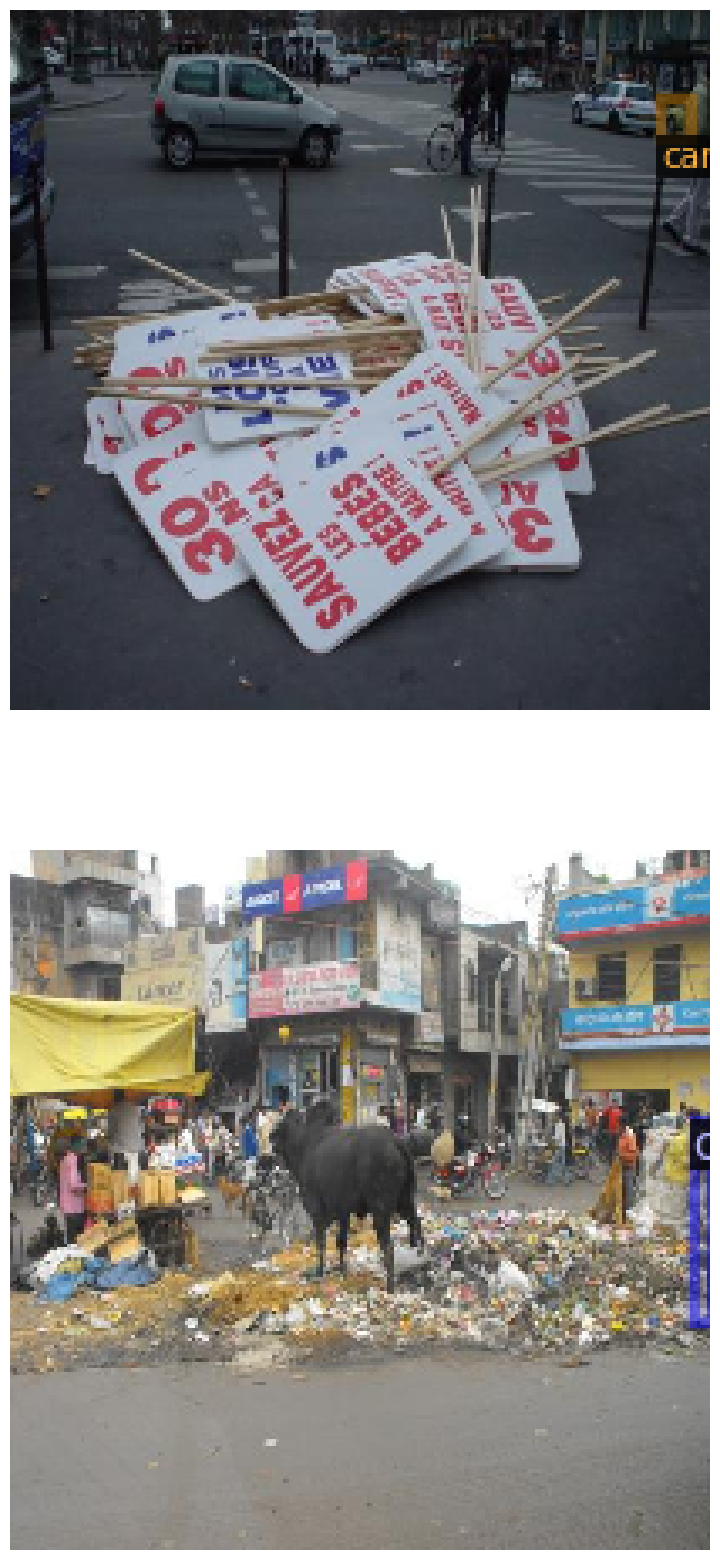

In [47]:
fig, ax = plt.subplots(2, 1, figsize =(35,20))
i=-1
for d in random.sample(dataset_dicts_train, 2):
    i=i+1    
    img = cv2.imread(d["file_name"]+'.jpg')
    v = Visualizer(img[:, :, :],
                   metadata=metadata_dicts_train, 
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    ax[i].grid(False)
    ax[i].axis('off')
    ax[i].imshow(out.get_image()[:, :, ::-1])